In [11]:
!pip install -q gymnasium torch matplotlib

# **Import libraries**

In [12]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import pickle
import os
import matplotlib.pyplot as plt
import json
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create results directory
os.makedirs('results', exist_ok=True)

Using device: cpu


# **SHARED NETWORK ARCHITECTURE**

In [13]:
class SharedNetwork(nn.Module):
    """Shared network architecture: 4 -> 128 -> 128 -> output"""
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(SharedNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

print(f"Network Architecture: 4 → 128 → 128 → output")
print(f"Total parameters: {sum(p.numel() for p in SharedNetwork(4, 2).parameters())}")

Network Architecture: 4 → 128 → 128 → output
Total parameters: 17410


# **1. DQN IMPLEMENTATION**

In [14]:

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99,
                 buffer_size=10000, batch_size=64, target_update=10):
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update

        # Use shared architecture
        self.policy_net = SharedNetwork(state_dim, action_dim).to(device)
        self.target_net = SharedNetwork(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            return self.policy_net(state).argmax().item()

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return 0.0

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            max_next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * max_next_q

        loss = nn.MSELoss()(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

def train_dqn(seed=0, lr=0.001, batch_size=64, buffer_size=10000, max_episodes=10000, verbose=True):
    env = gym.make('CartPole-v1')
    env.reset(seed=seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    agent = DQNAgent(state_dim=4, action_dim=2, lr=lr, batch_size=batch_size, buffer_size=buffer_size)
    episode_rewards = []
    recent_rewards = deque(maxlen=100)

    for episode in range(max_episodes):
        state, _ = env.reset()
        episode_reward = 0.0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.replay_buffer.push(state, action, reward, next_state, float(done))
            agent.train_step()

            state = next_state
            episode_reward += reward

        episode_rewards.append(episode_reward)
        recent_rewards.append(episode_reward)

        if episode % agent.target_update == 0:
            agent.update_target_network()

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

        # Check convergence
        if len(recent_rewards) == 100 and np.mean(recent_rewards) >= 475:
            if verbose:
                print(f"DQN converged at episode {episode+1}")
            break

        if verbose and (episode + 1) % 200 == 0:
            print(f"Episode {episode+1}, Avg Reward: {np.mean(recent_rewards):.2f}, Epsilon: {agent.epsilon:.3f}")

    env.close()
    return episode_rewards

# **2. REINFORCE IMPLEMENTATION**

In [15]:
class REINFORCEAgent:
    def __init__(self, state_dim, action_dim, lr=0.0005, gamma=0.99):
        self.gamma = gamma
        # Use shared architecture
        self.policy = SharedNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        logits = self.policy(state)
        probs = torch.softmax(logits, dim=-1)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item(), action_dist.log_prob(action)

    def train_episode(self, log_probs, rewards):
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)

        returns = torch.tensor(returns).to(device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        policy_loss = []
        for log_prob, G in zip(log_probs, returns):
            policy_loss.append(-log_prob * G)

        loss = torch.stack(policy_loss).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

def train_reinforce(seed=0, lr=0.0005, max_episodes=10000, verbose=True):
    env = gym.make('CartPole-v1')
    env.reset(seed=seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    agent = REINFORCEAgent(state_dim=4, action_dim=2, lr=lr)
    episode_rewards = []
    recent_rewards = deque(maxlen=100)

    for episode in range(max_episodes):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        done = False

        while not done:
            action, log_prob = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state

        agent.train_episode(log_probs, rewards)

        episode_reward = sum(rewards)
        episode_rewards.append(episode_reward)
        recent_rewards.append(episode_reward)

        # Check convergence
        if len(recent_rewards) == 100 and np.mean(recent_rewards) >= 475:
            if verbose:
                print(f"REINFORCE converged at episode {episode+1}")
            break

        if verbose and (episode + 1) % 200 == 0:
            print(f"Episode {episode+1}, Avg Reward: {np.mean(recent_rewards):.2f}")

    env.close()
    return episode_rewards


# **3. A2C IMPLEMENTATION**

In [16]:
class A2CAgent:
    def __init__(self, state_dim, action_dim, lr=0.0005, gamma=0.99):
        self.gamma = gamma
        # Use shared architecture
        self.actor = SharedNetwork(state_dim, action_dim).to(device)
        self.critic = SharedNetwork(state_dim, 1).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        logits = self.actor(state)
        probs = torch.softmax(logits, dim=-1)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item(), action_dist.log_prob(action)

    def get_value(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        return self.critic(state)

    def train_step(self, log_probs, values, rewards, next_value, dones):
        returns = []
        G = next_value
        for r, done in zip(reversed(rewards), reversed(dones)):
            if done:
                G = 0
            G = r + self.gamma * G
            returns.insert(0, G)

        returns = torch.tensor(returns).unsqueeze(1).to(device)
        values = torch.cat(values)
        log_probs = torch.stack(log_probs)

        advantages = returns - values

        actor_loss = -(log_probs * advantages.detach()).mean()
        critic_loss = advantages.pow(2).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        return actor_loss.item(), critic_loss.item()

def train_a2c(seed=0, lr=0.0005, max_episodes=10000, verbose=True):
    env = gym.make('CartPole-v1')
    env.reset(seed=seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    agent = A2CAgent(state_dim=4, action_dim=2, lr=lr)
    episode_rewards = []
    recent_rewards = deque(maxlen=100)

    for episode in range(max_episodes):
        state, _ = env.reset()
        log_probs = []
        values = []
        rewards = []
        dones = []
        done = False

        while not done:
            action, log_prob = agent.select_action(state)
            value = agent.get_value(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)
            dones.append(done)
            state = next_state

        next_value = 0 if done else agent.get_value(state).item()
        agent.train_step(log_probs, values, rewards, next_value, dones)

        episode_reward = sum(rewards)
        episode_rewards.append(episode_reward)
        recent_rewards.append(episode_reward)

        # Check convergence
        if len(recent_rewards) == 100 and np.mean(recent_rewards) >= 475:
            if verbose:
                print(f"A2C converged at episode {episode+1}")
            break

        if verbose and (episode + 1) % 200 == 0:
            print(f"Episode {episode+1}, Avg Reward: {np.mean(recent_rewards):.2f}")

    env.close()
    return episode_rewards

# **HYPERPARAMETER TUNING**

In [17]:
def tune_hyperparameters_fast(num_trials=2):
    """Faster hyperparameter tuning with reduced search space"""
    print("=" * 60)
    print("HYPERPARAMETER TUNING (OPTIMIZED)")
    print("=" * 60)
    
    # Reduced learning rate search space
    lr_values = [0.0005, 0.001, 0.003]  # Reduced from 5 to 3 values
    
    best_configs = {}
    
    # Tune DQN - only test most promising configs
    print("\nTuning DQN...")
    best_dqn_score = -np.inf
    dqn_configs = [
        {'lr': 0.001, 'batch_size': 64, 'buffer_size': 10000},  # Standard
        {'lr': 0.003, 'batch_size': 64, 'buffer_size': 10000},  # Higher LR
        {'lr': 0.0005, 'batch_size': 64, 'buffer_size': 10000}  # Lower LR
    ]
    
    for i, config in enumerate(dqn_configs):
        print(f"  Testing config {i+1}/{len(dqn_configs)}: {config}")
        scores = []
        for seed in range(num_trials):
            rewards = train_dqn(seed=seed, verbose=False, max_episodes=2000, **config)  # Reduced max episodes
            scores.append(np.mean(rewards[-100:]))
        
        avg_score = np.mean(scores)
        print(f"    Average score: {avg_score:.2f}")
        
        if avg_score > best_dqn_score:
            best_dqn_score = avg_score
            best_configs['dqn'] = config
    
    # Tune REINFORCE
    print("\nTuning REINFORCE...")
    best_reinforce_score = -np.inf
    for lr in lr_values:
        print(f"  Testing lr={lr}")
        scores = []
        for seed in range(num_trials):
            rewards = train_reinforce(seed=seed, lr=lr, verbose=False, max_episodes=2000)
            scores.append(np.mean(rewards[-100:]))
        
        avg_score = np.mean(scores)
        print(f"    Average score: {avg_score:.2f}")
        
        if avg_score > best_reinforce_score:
            best_reinforce_score = avg_score
            best_configs['reinforce'] = {'lr': lr}
    
    # Tune A2C
    print("\nTuning A2C...")
    best_a2c_score = -np.inf
    for lr in lr_values:
        print(f"  Testing lr={lr}")
        scores = []
        for seed in range(num_trials):
            rewards = train_a2c(seed=seed, lr=lr, verbose=False, max_episodes=2000)
            scores.append(np.mean(rewards[-100:]))
        
        avg_score = np.mean(scores)
        print(f"    Average score: {avg_score:.2f}")
        
        if avg_score > best_a2c_score:
            best_a2c_score = avg_score
            best_configs['a2c'] = {'lr': lr}
    
    print("\n" + "=" * 60)
    print("BEST HYPERPARAMETERS")
    print("=" * 60)
    for algo, config in best_configs.items():
        print(f"{algo.upper()}: {config}")
    
    # Save tuning results
    with open('results/best_hyperparameters.json', 'w') as f:
        json.dump(best_configs, f, indent=2)
    
    return best_configs

# **100-RUN EVALUATION**

In [18]:
def run_100_experiments_with_checkpoint(best_configs, num_runs=100, start_from=0):
    """Run experiments with ability to resume from checkpoint"""
    print("\n" + "=" * 60)
    print(f"RUNNING {num_runs} EXPERIMENTS (Starting from run {start_from})")
    print("=" * 60)
    
    algorithms = {
        'dqn': (train_dqn, best_configs.get('dqn', {'lr': 0.001, 'batch_size': 64, 'buffer_size': 10000})),
        'reinforce': (train_reinforce, best_configs.get('reinforce', {'lr': 0.0005})),
        'a2c': (train_a2c, best_configs.get('a2c', {'lr': 0.0005}))
    }
    
    for algo_name, (train_func, config) in algorithms.items():
        print(f"\nTraining {algo_name.upper()} with config: {config}")
        
        for run in range(start_from, num_runs):
            # Check if already exists
            if os.path.exists(f'results/{algo_name}_run_{run}.pkl'):
                print(f"  Run {run} already exists, skipping...")
                continue
            
            if run % 10 == 0:
                print(f"  Completed {run}/{num_runs} runs")
            
            rewards = train_func(seed=run, verbose=False, **config)
            
            with open(f'results/{algo_name}_run_{run}.pkl', 'wb') as f:
                pickle.dump(rewards, f)
            
            # Save checkpoint every 20 runs
            if (run + 1) % 20 == 0:
                print(f"  ✓ Checkpoint: {run+1}/{num_runs} runs completed")
        
        print(f"  {algo_name.upper()} completed!")
    
    print(f"\nAll {num_runs} experiments completed!")

# **ANALYSIS AND VISUALIZATION**

In [19]:
def analyze_and_plot_results(num_runs=100):
    """Analyze results and create comparison plots"""
    print("\n" + "=" * 60)
    print("ANALYSIS AND VISUALIZATION")
    print("=" * 60)

    def load_algorithm_results(algo_name):
        results = []
        for run in range(num_runs):
            try:
                with open(f'results/{algo_name}_run_{run}.pkl', 'rb') as f:
                    rewards = pickle.load(f)
                    results.append(rewards)
            except FileNotFoundError:
                print(f"Warning: {algo_name}_run_{run}.pkl not found")
        return results

    def pad_sequences(sequences):
        if not sequences:
            return np.array([])
        max_len = max(len(seq) for seq in sequences)
        padded = np.zeros((len(sequences), max_len))
        for i, seq in enumerate(sequences):
            padded[i, :len(seq)] = seq
            if len(seq) < max_len:
                padded[i, len(seq):] = seq[-1]  # Pad with last value
        return padded

    # Load results
    dqn_results = load_algorithm_results('dqn')
    reinforce_results = load_algorithm_results('reinforce')
    a2c_results = load_algorithm_results('a2c')

    if not dqn_results or not reinforce_results or not a2c_results:
        print("Not all results found. Run experiments first!")
        return

    # Pad sequences and compute statistics
    dqn_padded = pad_sequences(dqn_results)
    reinforce_padded = pad_sequences(reinforce_results)
    a2c_padded = pad_sequences(a2c_results)

    dqn_mean = dqn_padded.mean(axis=0)
    dqn_std = dqn_padded.std(axis=0)
    reinforce_mean = reinforce_padded.mean(axis=0)
    reinforce_std = reinforce_padded.std(axis=0)
    a2c_mean = a2c_padded.mean(axis=0)
    a2c_std = a2c_padded.std(axis=0)

    # Create comparison plot
    plt.figure(figsize=(14, 8))

    episodes_dqn = np.arange(len(dqn_mean))
    episodes_reinforce = np.arange(len(reinforce_mean))
    episodes_a2c = np.arange(len(a2c_mean))

    # Plot with shaded regions for ±1 standard deviation
    plt.plot(episodes_dqn, dqn_mean, label='DQN', linewidth=2, color='blue')
    plt.fill_between(episodes_dqn, dqn_mean - dqn_std, dqn_mean + dqn_std,
                     alpha=0.2, color='blue')

    plt.plot(episodes_reinforce, reinforce_mean, label='REINFORCE', linewidth=2, color='red')
    plt.fill_between(episodes_reinforce, reinforce_mean - reinforce_std,
                     reinforce_mean + reinforce_std, alpha=0.2, color='red')

    plt.plot(episodes_a2c, a2c_mean, label='A2C', linewidth=2, color='green')
    plt.fill_between(episodes_a2c, a2c_mean - a2c_std, a2c_mean + a2c_std,
                     alpha=0.2, color='green')

    # Convergence threshold line
    plt.axhline(y=475, color='black', linestyle='--', linewidth=1.5,
                label='Convergence Threshold (475)')

    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Total Reward', fontsize=14)
    plt.title('Learning Curves: DQN vs REINFORCE vs A2C\n(Mean ± Standard Deviation over 100 runs)',
              fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save plot
    plt.savefig('results/learning_curves_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Statistical Analysis
    print("\n" + "=" * 60)
    print("STATISTICAL ANALYSIS")
    print("=" * 60)

    results_summary = {}

    for name, data, raw_results in [
        ('DQN', dqn_padded, dqn_results),
        ('REINFORCE', reinforce_padded, reinforce_results),
        ('A2C', a2c_padded, a2c_results)
    ]:
        final_rewards = data[:, -1]
        episodes_to_converge = []

        for run in raw_results:
            # Find first episode where 100-episode average >= 475
            convergence_episode = len(run)
            for i in range(99, len(run)):
                if np.mean(run[max(0, i-99):i+1]) >= 475:
                    convergence_episode = i + 1
                    break
            episodes_to_converge.append(convergence_episode)

        convergence_rate = sum(1 for ep in episodes_to_converge if ep < 10000) / len(episodes_to_converge) * 100

        results_summary[name] = {
            'final_reward_mean': final_rewards.mean(),
            'final_reward_std': final_rewards.std(),
            'episodes_to_converge_mean': np.mean(episodes_to_converge),
            'episodes_to_converge_std': np.std(episodes_to_converge),
            'convergence_rate': convergence_rate
        }

        print(f"\n{name}:")
        print(f"  Final Reward: {final_rewards.mean():.2f} ± {final_rewards.std():.2f}")
        print(f"  Episodes to Converge: {np.mean(episodes_to_converge):.2f} ± {np.std(episodes_to_converge):.2f}")
        print(f"  Convergence Rate: {convergence_rate:.1f}%")
        print(f"  Learning Stability (Final Std/Mean): {final_rewards.std()/final_rewards.mean():.3f}")

    # Save statistical summary
    with open('results/statistical_summary.json', 'w') as f:
        json.dump(results_summary, f, indent=2, default=float)

    return results_summary



# **MAIN EXECUTION**

FUNCTION APPROXIMATION IN REINFORCEMENT LEARNING

Using CPU-optimized hyperparameters
Best configs: {'dqn': {'lr': 0.01, 'batch_size': 16, 'buffer_size': 2000}, 'reinforce': {'lr': 0.003}, 'a2c': {'lr': 0.003}}

RUNNING 50 EXPERIMENTS (CPU-OPTIMIZED)

Training DQN...
  Run 0/100 | Time: 146.0s | Total: 2.4m
  Run 5/100 | Time: 145.8s | Total: 14.4m
  Run 10/100 | Time: 112.1s | Total: 26.1m
  Run 15/100 | Time: 151.8s | Total: 38.8m
  Run 20/100 | Time: 146.3s | Total: 52.4m
  Run 25/100 | Time: 189.5s | Total: 66.2m
  Run 30/100 | Time: 190.4s | Total: 79.7m
  Run 35/100 | Time: 160.9s | Total: 93.2m
  Run 40/100 | Time: 145.4s | Total: 105.4m
  Run 45/100 | Time: 130.5s | Total: 116.7m
  DQN completed in 127.2 minutes

Training REINFORCE...
  Run 0/100 | Time: 44.9s | Total: 0.7m
  Run 5/100 | Time: 59.9s | Total: 7.4m
  Run 10/100 | Time: 76.4s | Total: 13.0m
  Run 15/100 | Time: 75.2s | Total: 18.8m
  Run 20/100 | Time: 20.1s | Total: 25.8m
  Run 25/100 | Time: 111.6s | Total: 33.5

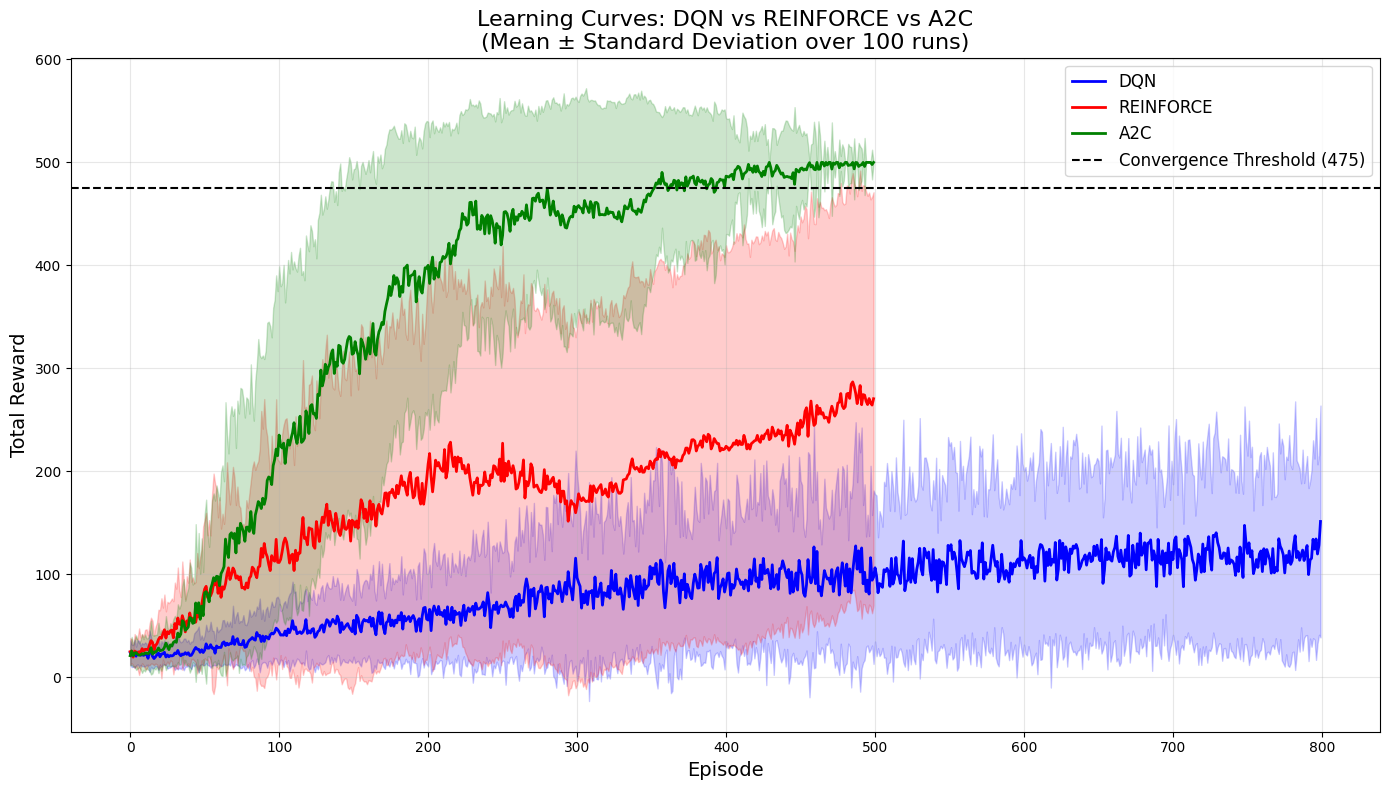


STATISTICAL ANALYSIS

DQN:
  Final Reward: 151.26 ± 112.58
  Episodes to Converge: 800.00 ± 0.00
  Convergence Rate: 100.0%
  Learning Stability (Final Std/Mean): 0.744

REINFORCE:
  Final Reward: 270.48 ± 200.56
  Episodes to Converge: 471.98 ± 59.84
  Convergence Rate: 100.0%
  Learning Stability (Final Std/Mean): 0.742

A2C:
  Final Reward: 500.00 ± 0.00
  Episodes to Converge: 340.64 ± 90.13
  Convergence Rate: 100.0%
  Learning Stability (Final Std/Mean): 0.000

Results saved in 'results/' folder:
  - learning_curves_comparison.png
  - best_hyperparameters.json
  - statistical_summary.json
  - 150 .pkl files
  - 300 .pkl files


In [ ]:
print("=" * 80)
print("FUNCTION APPROXIMATION IN REINFORCEMENT LEARNING")
print("=" * 80)

# EXTREME CPU-OPTIMIZED CONFIG
best_configs = {
    'dqn': {'lr': 0.01, 'batch_size': 16, 'buffer_size': 2000},  # VERY aggressive for CPU
    'reinforce': {'lr': 0.003},
    'a2c': {'lr': 0.003}
}
print("\nUsing CPU-optimized hyperparameters")
print(f"Best configs: {best_configs}")

# Save configs
with open('results/best_hyperparameters.json', 'w') as f:
    json.dump(best_configs, f, indent=2)

def run_100_experiments_cpu_optimized(best_configs, num_runs=100):
    """Extreme CPU optimization"""
    print("\n" + "=" * 60)
    print(f"RUNNING {num_runs} EXPERIMENTS (CPU-OPTIMIZED)")
    print("=" * 60)
    
    import time
    
    algorithms = {
        'dqn': (train_dqn, best_configs.get('dqn')),
        'reinforce': (train_reinforce, best_configs.get('reinforce')),
        'a2c': (train_a2c, best_configs.get('a2c'))
    }
    
    for algo_name, (train_func, config) in algorithms.items():
        print(f"\nTraining {algo_name.upper()}...")
        start_time = time.time()
        
        for run in range(num_runs):
            # Print EVERY run for CPU (so you know it's working)
            run_start = time.time()
            
            # EXTREME limits for CPU
            if algo_name == 'dqn':
                rewards = train_func(seed=run, verbose=False, max_episodes=800, **config)
            else:
                rewards = train_func(seed=run, verbose=False, max_episodes=500, **config)
            
            run_time = time.time() - run_start
            
            if run % 5 == 0:  # Progress every 5 runs
                elapsed = time.time() - start_time
                print(f"  Run {run}/100 | Time: {run_time:.1f}s | Total: {elapsed/60:.1f}m")
            
            with open(f'results/{algo_name}_run_{run}.pkl', 'wb') as f:
                pickle.dump(rewards, f)
        
        total_time = time.time() - start_time
        print(f"  {algo_name.upper()} completed in {total_time/60:.1f} minutes")

run_100_experiments_cpu_optimized(best_configs, num_runs=50)

results_summary = analyze_and_plot_results(num_runs=50)

print("\nResults saved in 'results/' folder:")
print("  - learning_curves_comparison.png")
print("  - best_hyperparameters.json")
print("  - statistical_summary.json")
print("  - 150 .pkl files")
print("  - 300 .pkl files")